# Topic Modelling using Latent Semantic Analysis (LSA) and Latent Dirichlet Allocation (LDA) in sklearn

## Import Library

### Library yang digunakan

- **Pandas**

    Untuk manipulasi dan membaca data dalam bentuk tabel 

- **matplotlib**

    Untuk membuat visualisasi data

<!-- - **seaborn** -->
- **PySastrawi**

    Untuk melakukan text processing

- **scikit-learn**

    Untuk menghitung TF dan TF-IDF

In [1]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
# import seaborn as sns
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
# sns.set(style='whitegrid',color_codes=True)

import re
import string
#import nltk
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize,sent_tokenize

# #preprocessing
# from nltk.corpus import stopwords  #stopwords
# from nltk import word_tokenize,sent_tokenize # tokenizing
# from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
# from nltk.stem.snowball import SnowballStemmer
# from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

# # for named entity recognition (NER)
# from nltk import ne_chunk

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#stop-words
# stop_words=set(nltk.corpus.stopwords.words('english'))

In [2]:
# Melakukan setting jumlah kolom maksimal pada output
pd.options.display.max_columns = 10

## Membaca Data

In [3]:
df = pd.read_csv('dataset_pta.csv')

In [4]:
df.head()

,judul,abstraksi,bidang minat
0,Gerak Pekerja Pada Game Real Time Strategy Men...,Gerak pekerja ada pada game yang memiliki genr...,CAI
1,PEMANFAATAN TOGAF ADM UNTUK PERANCANGAN SISTEM...,Penyusunan Sistem Informasi Dinas Perindustria...,RPL
2,RANCANG BANGUN MANAJEMEN PEMBELAJARAN DAN TES ...,Penggunaan teknologi mobile saat ini sangat ma...,RPL
3,SISTEM PENDUKUNG KEPUTUSAN PEMILIHAN KARYAWAN ...,Sumber daya manusia mutlak dibutuhkan untuk ke...,CAI
4,SISTEM PENENTUAN STATUS GIZI PASIEN RAWAT INAP...,Di Indonesia masalah perkembangan gizi adalah ...,CAI


Data yang digunakan dalam program ini hanya data pada kolom 'judul'. Untuk mengambil kolom 'judul' saja dapat dilakukan dengan inisialisasi ulang df dengan df[['judul']] 

In [5]:
df = df[['judul']]
df.head()

,judul
0,Gerak Pekerja Pada Game Real Time Strategy Men...
1,PEMANFAATAN TOGAF ADM UNTUK PERANCANGAN SISTEM...
2,RANCANG BANGUN MANAJEMEN PEMBELAJARAN DAN TES ...
3,SISTEM PENDUKUNG KEPUTUSAN PEMILIHAN KARYAWAN ...
4,SISTEM PENENTUAN STATUS GIZI PASIEN RAWAT INAP...


## Pre-processing Data

Terdapat beberapa tahapan dalam melakukan Pre-processing data, diantaranya *case folding* (Mengubah teks menjadi *lower case*), menghapus angka dan tanda baca, menghapus white space dan *stopword removal*. Semua tahapan *pre-processing* tersebut saya masukkan ke dalam fungsi clean_text, kemudian saya aplikasikan pada data judul pada dataframe dengan method **.apply(clean_text)**. 

Untuk menghapus stopword saya menggunakan library **PySastrawi**, karena **PySastrawi** memiliki list stopword bahasa indonesia yang lebih lengkap daripada library **nltk**.

Pada Library **PySastrawi** penghapusan stopword dilakukan dengan membuata objek StopWordRemoverFactory, kemudian buat objek stopword remover dengan method create_stop_word_remover. Objek stopword remover memiliki method remove yang dapat digunakan untuk menghapus stopword dalam sebuah kalimat dengan memasukkan string ke dalam parameter method remove.  

In [6]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

In [7]:
def clean_text(text):
  # Mengubah teks menjadi lowercase
  cleaned_text = text.lower()
  # Menghapus angka
  cleaned_text = re.sub(r"\d+", "", cleaned_text)
  # Menghapus white space
  cleaned_text = cleaned_text.strip()
  # Menghapus tanda baca
  cleaned_text = cleaned_text.translate(str.maketrans("","",string.punctuation))
  # Hapus stopword
  cleaned_text = stopword.remove(cleaned_text)
  return cleaned_text
  

In [8]:
# time taking
df['cleaned_judul'] = df['judul'].apply(clean_text)

### Perbedaan data awal dengan data yang telah di-preprocessing

In [9]:
df.head()

,judul,cleaned_judul
0,Gerak Pekerja Pada Game Real Time Strategy Men...,gerak pekerja game real time strategy finite s...
1,PEMANFAATAN TOGAF ADM UNTUK PERANCANGAN SISTEM...,pemanfaatan togaf adm perancangan sistem infor...
2,RANCANG BANGUN MANAJEMEN PEMBELAJARAN DAN TES ...,rancang bangun manajemen pembelajaran tes toef...
3,SISTEM PENDUKUNG KEPUTUSAN PEMILIHAN KARYAWAN ...,sistem pendukung keputusan pemilihan karyawan ...
4,SISTEM PENENTUAN STATUS GIZI PASIEN RAWAT INAP...,sistem penentuan status gizi pasien rawat inap...


### Hapus kolom 'judul'

In [10]:
df.drop(['judul'],axis=1,inplace=True)

### Mengganti nama kolom __cleaned_judul__ dengan __judul__ 

In [11]:
df.columns = ['judul']

In [12]:
df.head()

,judul
0,gerak pekerja game real time strategy finite s...
1,pemanfaatan togaf adm perancangan sistem infor...
2,rancang bangun manajemen pembelajaran tes toef...
3,sistem pendukung keputusan pemilihan karyawan ...
4,sistem penentuan status gizi pasien rawat inap...


### Contoh judul yang telah di lakukan *pre-processing*

In [13]:
df['judul'][0]

'gerak pekerja game real time strategy finite state machine'

## Ekstraksi fitur dan membuat Document Term Matrix (DTM)

Dalam perhitungan LSA (Latent Semantic Analysis) data yang diperlukan hanya TF-IDF. Sehingga pada program ini tidak perlu mencari nilai TF dari dokumen. Untuk mengetahui nilai TF-IDF dapat dilakukan dengan membuat objek dari kelas TfidfVectorizer yang disediakan library scikit-learn.

Rumus Term Frequency:
$$
tf(t,d) = { f_{ t,d } \over \sum_{t' \in d } f_{t,d}}
$$

$ f_{ t,d } \quad\quad\quad\quad$: Jumlah kata t muncul dalam dokumen

$ \sum_{t' \in d } f_{t,d} \quad\quad$: Jumlah seluruh kata yang ada dalam dokumen

Rumus Inverse Document Frequency:
$$
idf( t,D ) = log { N \over { | \{ d \in D:t \in d \} | } }
$$

$ N \quad\quad\quad\quad\quad$ : Jumlah seluruh dokumen

$ | \{ d \in D:t \in d \} | $ : Jumlah dokumen yang mengandung kata $ t $

Rumus Inverse Document Frequency:
$$
tfidf( t,d,D ) = tf( t,d ) \times idf( t,D )
$$

In [14]:
vect = TfidfVectorizer()

Setelah objek **TfidfVectorizer** dibuat gunakan method **fit_transform** dengan argumen data yang akan dicari nilai **TF-IDF**-nya

In [15]:
vect_text = vect.fit_transform(df['judul'])

In [16]:
attr_count = vect.get_feature_names_out().shape[0]
print(f'Jumlah atribut dalam Document-Term Matrix : {attr_count}')

Jumlah atribut dalam Document-Term Matrix : 358


#### Menyimpan hasil tfidf ke dalam DataFrame

Hasil tfidf perlu diubah terlebih dahulu menjadi array agar dapat digunakan sebagai data. Kemudian untuk parameter kolom-nya dapat didapatkan menggunakan method get_feature_names_out pada objek TfidfVectorizer.

In [17]:
tfidf = pd.DataFrame(
    data=vect_text.toarray(),
    columns=vect.get_feature_names_out()
)
tfidf.head()

,acute,addie,additive,additiveweighting,adm,...,wafa,wajah,web,weight,weighting
0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.300817,...,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0


Mencari nilai **idf** dengan mengakses atribut **idf_** pada objek **tfidfVectorizer**. Atribut **idf_** hanya terdefinisi apabila parameter **use_idf** saat instansiasi objekk tfidfVectorizer bernilai **True**. Namun, **use_idf** sudah bernilai **True** secara default, sehingga kita dapat perlu menentukannya secara manual. 

In [18]:
idf = vect.idf_

In [19]:
dd= dict(zip(vect.get_feature_names_out(), idf))

l = sorted(dd, key = dd.get)

Kita dapat melihat kata yang paling sering dan paling jarang muncul pada judul tugas akhir berdasarkan nilai idf. Kata yang memiliki nilai lebih kecil, adalah kata yang paling sering muncul dalam judul

In [20]:
print("5 Kata paling sering muncul:")
for i, word in enumerate(l[:5]):
    print(f"{i+1}. {word}\t(Nilai idf: {dd[word]})")

5 Kata paling sering muncul:
1. sistem	(Nilai idf: 1.709676482511156)
2. metode	(Nilai idf: 1.9753796482441615)
3. berbasis	(Nilai idf: 2.11514159061932)
4. studi	(Nilai idf: 2.220502106277147)
5. rancang	(Nilai idf: 2.3382851419335298)


In [21]:
print("5 Kata paling jarang muncul:")
for i, word in enumerate(l[:-5:-1]):
    print(f"{i+1}. {word}\t(Nilai idf: {dd[word]})")

5 Kata paling jarang muncul:
1. weighting	(Nilai idf: 4.417726683613366)
2. weight	(Nilai idf: 4.417726683613366)
3. wajah	(Nilai idf: 4.417726683613366)
4. wafa	(Nilai idf: 4.417726683613366)


## TOPIC MODELLING

### Latent Semantic Analysis (LSA)

Latent Semantic Analysis (LSA) merupakan sebuah metode yang memanfaatkan model statistik matematis untuk menganalisa struktur semantik suatu teks. LSA bisa digunakan untuk menilai judul tugas akhir dengan mengkonversikan judul tugas akhir menjadi matriks-matriks yang diberi nilai pada masing-masing term untuk dicari kesamaan dengan term. Secara umum, langkah-langkah LSA dalam penilaian judul tugas akhir adalah sebagai berikut:

1. Text Processing
2. Document-Term Matrix
3. Singular Value Decomposition (SVD)
4. Cosine Similarity Measurement

#### Singular Value Decomposition

Singular Value Decomposition (SVD) adalah sebuah teknik untuk mereduksi dimensi yang bermanfaat untuk memperkecil nilai kompleksitas dalam pemrosesan Document-Term Matrix. SVD merupakan teorema aljabar linier yang menyebutkan bahwa persegi panjang dari Document-Term Matrix dapat dipecah/didekomposisikan menjadi tiga matriks, yaitu Matriks ortogonal U, Matriks diagonal S, Transpose dari matriks ortogonal V.

$$
A_{mn} = U_{mm} \times S_{mn} \times V^{T}_{nn}
$$

$ A_{mn} $ : matriks awal

$ U_{mm} $ : matriks ortogonal

$ S_{mn} $ : matriks diagonal

$ V^{T}_{nn} $ : Transpose matriks ortogonal V

Setiap baris dari matriks $ U $ (Document-Term Matrix) adalah bentuk vektor dari dokumen. Panjang dari vektor-vektor tersebut adalah jumlah topik. Sedangkan matriks $ V $ (Term-Topic Matrix) berisi kata-kata dari data.

SVD akan memberikan vektor untuk setiap dokumen dan kata dalam data. Kita dapat menggunakan vektor-vektor tersebut untuk mencari kata dan dokumen serupa menggunakan metode **Cosine Similarity**.

Dalam mengimplementasikan LSA, dapat menggunakan fungsi TruncatedSVD. parameter n_components digunakan untuk menentukan jumlah topik yang akan diekstrak.



In [22]:
from sklearn.decomposition import TruncatedSVD
lsa_model = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=10, random_state=42)

lsa_top=lsa_model.fit_transform(vect_text)


In [23]:
l=lsa_top[0]
print("Document 0 :")
for i,topic in enumerate(l):
  print(f"Topic {i} : {topic*100}")

Document 0 :
Topic 0 : 1.3810694835999033
Topic 1 : -3.384805564095132


In [24]:
print(lsa_model.components_.shape) # (no_of_topics*no_of_words)
print(lsa_model.components_)

(2, 358)
[[ 2.51819953e-03  2.30536559e-02  4.96783611e-02  1.66791646e-02
   1.21478443e-02  1.06691713e-02  1.64312006e-01  4.60945596e-03
   1.31382585e-02  2.57108543e-03  1.35197378e-02  1.16864700e-03
   1.18886238e-02  3.90123454e-02  1.93272980e-02  1.06691713e-02
   5.03942446e-03  9.68413088e-03  1.16187254e-02  1.06691713e-02
   1.30638374e-01  3.40690009e-02  4.97201815e-03  1.70472104e-01
   3.43759066e-02  1.21478443e-02  3.19848580e-02  4.54722012e-02
   1.27042090e-02  4.53201912e-03  9.39182317e-03  6.32334607e-02
   6.33490936e-02  2.66229229e-01  9.03513251e-03  1.31382585e-02
   2.86381013e-02  1.82686484e-02  2.01923481e-02  1.18886238e-02
   2.23859456e-01  2.08227246e-03  1.12586867e-02  1.06691713e-02
   7.26258938e-03  7.26258938e-03  1.16864700e-03  1.92162911e-02
   1.06691713e-02  2.51819953e-03  7.06590019e-03  1.33387377e-02
   1.26908241e-03  1.07120829e-02  1.16864700e-03  7.28563194e-02
   3.91336976e-03  1.33387377e-02  3.91336976e-03  1.33387377e-02
 

Sekarang kita dapat mendapatkan daftar kata yang penting untuk setiap topik. Jumlah kata yang akan ditampilkan hanya 10. Untuk melakukan sorting dapat menggunakan fungsi sorted, lalu slicing dengan menambahkan \[:10\] agar data yang diambil hanya 10 data pertama. Slicing dilakukan berdasarkan nilai pada indeks 1 karena nilai dari nilai lsa.

In [25]:
# most important words for each topic
vocab = vect.get_feature_names_out()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)

    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print(f"Topic {i}: ")
    print(" ".join([ item[0] for item in sorted_words ]))
    
    print("\n")
         

Topic 0: 
studi sistem bangun rancang informasi madura berbasis trunojoyo universitas pembelajaran


Topic 1: 
keputusan pendukung metode sistem topsis penentuan pemilihan saw penilaian unggulan




## Latent Dirichlet Allocation (LDA)  

LDA is the most popular technique.**The topics then generate words based on their probability distribution. Given a dataset of documents, LDA backtracks and tries to figure out what topics would create those documents in the first place.**

**To understand the maths it seems as if knowledge of Dirichlet distribution (distribution of distributions) is required which is quite intricate and left fior now.**

To get an inituitive explanation of LDA checkout these blogs: [this](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/)  ,  [this](https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/)  ,[this](https://en.wikipedia.org/wiki/Topic_model)  ,  [this kernel on Kaggle](https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial)  ,  [this](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/) .

In [26]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=1) 
# n_components is the number of topics

In [27]:
lda_top=lda_model.fit_transform(vect_text)

In [28]:
print(lda_top.shape)  # (no_of_doc,no_of_topics)
print(lda_top)


(60, 10)
[[0.02506765 0.02506803 0.77438611 0.02506773 0.02506771 0.02506748
  0.02507135 0.02506834 0.02506822 0.02506738]
 [0.02134074 0.02134068 0.02134062 0.02134067 0.02133982 0.02133965
  0.80793778 0.02134052 0.02133957 0.02133995]
 [0.02681373 0.02681369 0.02681391 0.02681653 0.02681303 0.02681357
  0.0268133  0.02681397 0.75867473 0.02681353]
 [0.77888198 0.02456856 0.02456895 0.02456918 0.02456834 0.02456863
  0.02456919 0.02456832 0.02456855 0.0245683 ]
 [0.01949305 0.01949272 0.8245607  0.0194928  0.01949312 0.01949288
  0.01949258 0.01949286 0.01949309 0.0194962 ]
 [0.02582201 0.02582132 0.02582149 0.76760598 0.02582093 0.02582126
  0.02582207 0.02582171 0.02582241 0.02582083]
 [0.01839331 0.01839307 0.01839328 0.01839358 0.01839291 0.0183931
  0.01839291 0.83446178 0.01839291 0.01839315]
 [0.01890884 0.01890886 0.01890871 0.01890874 0.01890918 0.01890886
  0.0189086  0.01890871 0.01890882 0.82982068]
 [0.02247881 0.02247908 0.02247974 0.02247907 0.02247935 0.02247884
  0.

In [29]:
sum=0
for i in lda_top[0]:
  sum=sum+i
print(sum)  

1.0


#### Note that the values in a particular row adds to 1. This is beacuse each value denotes the % of contribution of the corressponding topic in the document.

$$
w_{i,j} = tf_{i,j} * log( {{N} \over {df_{j}}} )
$$

In [30]:
# composition of doc 0 for eg
print("Document 0: ")
for i,topic in enumerate(lda_top[0]):
  print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  2.506764556058844 %
Topic  1 :  2.5068028792686063 %
Topic  2 :  77.43861073961409 %
Topic  3 :  2.506773071935773 %
Topic  4 :  2.5067713200426867 %
Topic  5 :  2.506748361582034 %
Topic  6 :  2.5071348263653093 %
Topic  7 :  2.506833690079206 %
Topic  8 :  2.5068221393030763 %
Topic  9 :  2.506738415750372 %


#### As we can see Topic 7 & 8 are dominantly present in document 0.

 

In [31]:
print(lda_model.components_)
print(lda_model.components_.shape)  # (no_of_topics*no_of_words)

[[0.87031142 0.81813045 0.86144455 ... 0.95695632 0.90840999 0.74130744]
 [0.83822111 0.88967725 0.76679865 ... 0.81956378 0.83207606 0.76837742]
 [0.84843771 0.70941722 0.67795293 ... 0.76561665 0.73315086 0.78214288]
 ...
 [0.93665678 0.85297703 0.70973716 ... 1.01461444 0.73729604 0.81159876]
 [0.87981319 0.70945532 0.83266282 ... 0.88009208 0.83405424 0.78125423]
 [0.91097044 0.85381081 0.88053356 ... 0.82011364 0.81769613 0.86457689]]
(10, 358)


#### Most important words for a topic. (say 10 this time.)

In [32]:
# most important words for each topic
vocab = vect.get_feature_names_out()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
intelligent kabupaten industri trunojoyo pemilihan olahraga electre pendukung klasifikasi keputusan 

Topic 1: 
klasifikasi proses evaluasi arsip microsoft run android penilaian anggaran level 

Topic 2: 
pekerja finite rancang ii kejuruan arsitektur mining rule sawah ebusiness 

Topic 3: 
unggulan android aplikasi ltsa kamus smp informatika technique rancang sistem 

Topic 4: 
metho arsip rute akademik alphabet gps gizi linear phonics pemetaan 

Topic 5: 
service citra dosen pengolahan darah modified regresi leukemia simple pemerataan 

Topic 6: 
fakultas game correlation pemanfaatan pengambilan teknik madura pendataan knearest stkip 

Topic 7: 
kompetensi stkip penerima menengah translation edukasi tracking speech ahp time 

Topic 8: 
trunojoyo pembelajaran euclidean pertanian rancang aksesoris chain mobile tes gerak 

Topic 9: 
linear man coefficient media slamet metode pemerataan tulisan putih mdf 



#### To better visualize words in a topic we can see the word cloud. For each topic top 50 words are plotted.

In [33]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def draw_word_cloud(index):
  imp_words_topic=""
  comp=lda_model.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()
 

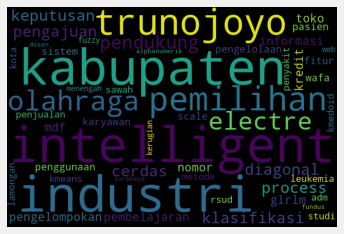

In [34]:
# topic 0
draw_word_cloud(0)


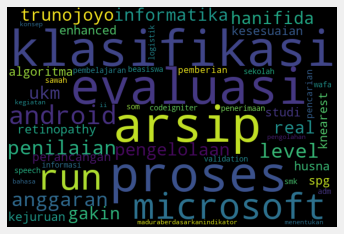

In [35]:
# topic 1
draw_word_cloud(1)  # ...